In [2]:
!pip install pysurvival
!pip install lifelines
!pip install osqp==0.5
!pip install scikit-survival
!pip install hyperopt

     |████████████████████████████████| 4.7 MB 4.3 MB/s 
  Created wheel for pysurvival: filename=pysurvival-0.1.2-cp37-cp37m-linux_x86_64.whl size=3773244 sha256=456cf411a53e681d34cd7b564e4c245a83036e92e26bbf5d592ed004376c923a
  Stored in directory: /root/.cache/pip/wheels/1a/63/e2/32273d765a4e2f4ccac69c8adf97425ca80bab5d0c8447f120
  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12082 sha256=1eb0182a0f0be4d1939bfaeae57bbb7074ff5e6c910385af10039668e373a561
  Stored in directory: /root/.cache/pip/wheels/f0/fd/1f/3e35ed57e94cd8ced38dd46771f1f0f94f65fec548659ed855
Successfully built pysurvival progressbar
     |████████████████████████████████| 348 kB 4.0 MB/s 
     |████████████████████████████████| 55 kB 3.9 MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4049 sha256=bfb084e66a815c10bb6d3619ee0951df0e9734c11a6f544ae6b87cc4bc623eb5
  Stored in directory: /root/.cache/pip/wheels/9f/01/ee/1331593abb5725ff7d8c1333

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as opt
from torch.distributions.weibull import Weibull
from torch.distributions.categorical import Categorical
from torch.distributions.mixture_same_family import MixtureSameFamily
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from lifelines.utils import concordance_index# as c_index
from sksurv.metrics import brier_score, integrated_brier_score, concordance_index_censored as ci_scikit
from hyperopt import hp
import hyperopt as ho
import dask
from copy import copy, deepcopy
%pylab inline
from google.colab import files
uploaded = files.upload()
torch.cuda.set_device(0)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Saving telecom.csv to telecom (1).csv


In [ ]:
#https://stackoverflow.com/questions/48152674/how-to-check-if-pytorch-is-using-the-gpu
seed = 7
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)
torch.cuda.is_available()

True

In [2]:
# Define default device, we should use the GPU (cuda) if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

In [2]:
import io 
df = pd.read_csv(io.BytesIO(uploaded['telecom.csv']))
ids = df[['customerID']]
df.drop(columns=['customerID'], inplace=True)
df

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [3]:
l = []
for j, i in enumerate(df['TotalCharges']):
    try:
        float(i)
    except ValueError:
        print(j, '_________', i)
        l.append(j)
df.drop(l, inplace = True ) 
df['TotalCharges'] = df['TotalCharges'].astype(float)
df = df.reset_index( drop = True )

488 _________  
753 _________  
936 _________  
1082 _________  
1340 _________  
3331 _________  
3826 _________  
4380 _________  
5218 _________  
6670 _________  
6754 _________  


In [4]:
binary = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
categorical = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']
numerical = ['tenure', 'SeniorCitizen', 'MonthlyCharges', 'TotalCharges']
df = pd.get_dummies(df, columns=binary, drop_first=True)
df = pd.get_dummies(df, columns=categorical)
# Creating the time and event columns
time_column = 'tenure'
event_column = 'Churn_Yes'
 
# Extracting the features
features = np.setdiff1d(df.columns, [time_column, event_column] ).tolist()

In [5]:
from sklearn.model_selection import train_test_split

index_train, index_test = train_test_split(range(df.shape[0]), test_size=0.3, random_state=0, stratify=df['Churn_Yes'])

tmp_data_train = df.loc[index_train].reset_index( drop = True )
data_test  = df.loc[index_test].reset_index( drop = True )

index_train, index_valid = train_test_split(tmp_data_train.index, test_size=0.2, random_state=0, stratify=tmp_data_train['Churn_Yes'])
data_train = tmp_data_train.loc[index_train].reset_index( drop = True )
data_valid = tmp_data_train.loc[index_valid].reset_index( drop = True )

 
# Creating the X, T and E inputs
X_train, X_valid, X_test = data_train[features], data_valid[features], data_test[features]
T_train, T_valid, T_test = data_train[time_column], data_valid[time_column], data_test[time_column]
E_train, E_valid, E_test = data_train[event_column], data_valid[event_column], data_test[event_column]
 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(X_train[['MonthlyCharges', 'TotalCharges']])
scaled_valid = scaler.fit_transform(X_valid[['MonthlyCharges', 'TotalCharges']])
scaled_test = scaler.transform(X_test[['MonthlyCharges', 'TotalCharges']])
X_train[['MonthlyCharges', 'TotalCharges']], X_valid[['MonthlyCharges', 'TotalCharges']], X_test[['MonthlyCharges', 'TotalCharges']] = scaled_train, scaled_valid, scaled_test

X_train.shape, X_valid.shape, X_test.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


((3937, 39), (985, 39), (2110, 39))

In [ ]:
E_train.shape

(3937,)

In [23]:
from torch import autograd
 
class NNModel(nn.Module):
    def __init__(self, input_shape, units=None, factors=None, dropout=None, slops=None):
        super().__init__()
        self.input_shape = input_shape
        self.units = units
        self.factors = factors
        self.network = nn.ModuleList()
        if self.factors:
            self.units = np.round(self.input_shape * np.asarray(self.factors)).astype(int)
        if self.units is not None:
            self.dropout = np.zeros_like(self.units) if dropout is None else dropout
            self.slops = np.full(len(self.units), 1.) if slops is None else slops
            for i, j, k in zip(self.units, self.dropout, self.slops):
                if i >= 1:
                    block = self.__build_block__(input_shape, i, p=j, slop=k)
                    self.network.extend(block)
                    input_shape = i
        self.output_shape = input_shape
        self.reset_parameters()
    
    def __build_block__(self, input_shape, units, p, slop, norm=False):
        block = []
        block.append(nn.Linear(input_shape, units, bias=not norm).double())
        if norm:
            #block.append(nn.BatchNorm1d(units).double())
            block.append(nn.LayerNorm(units, eps=1e-5).double())
        block.append(nn.ELU(slop))
        if p > 0:
            block.append(nn.Dropout(p))
        return block
 
    def forward(self, x):
        for layer in self.network:
          tmp = layer(x)
          x = tmp
        return x
 
    def reset_parameters(self):
        for layer in self.network:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_normal_(layer.weight)
                layer.bias.data.fill_(0.1)
 
    def get_weight(self):
        for layer in self.network:
            if isinstance(layer, nn.Linear):
                print('MAX WEIGHT = ', layer.weight.max())
                print('MIN WEIGHT = ', layer.weight.min())
 
    def get_grad(self):
        for layer in self.network:
            if isinstance(layer, nn.Linear):
                print('MAX GRAD = ', layer.weight.grad.max())
                print('MIN GRAD = ', layer.weight.grad.min())
 
 
class DenseBlock(nn.Module):
    def __init__(self, input_shape, nb_block, growth_rate, units, factors=None, dropout=0., slops=1.):
        super(DenseBlock, self).__init__()
        self.dropout = [dropout for i in range(nb_block)]
        self.slops = [slops for i in range(nb_block)]
        self.growth_rate = growth_rate
        self.network = nn.ModuleList()
        for j, k, l in zip(self.dropout, self.slops, range(nb_block)):
            block = NNModel(input_shape, units=[units], factors=factors, dropout=[j], slops=[k])
            self.network.extend([block])
            input_shape += units
            units += growth_rate
        self.input_shape = input_shape
        self.output_shape = units
 
    def forward(self, input):
        for block in self.network:
            x = block(input)
            input = torch.cat((input, x), 1)
        return input
 
class DenseNet(nn.Module):
    def __init__(self, input_layer, dense_blocks):
        super(DenseNet, self).__init__()
        self.input_layer = input_layer
        self.network = nn.ModuleList()
        self.network.extend(dense_blocks)
        self.output_shape = dense_blocks[-1].output_shape
 
    def forward(self, input):
        input = self.input_layer(input) if self.input_layer else input
        for i in self.network:
            input = i(input)
        return input
 
 
 
class SURV_DATA_LOADER(Dataset):
    def __init__(self, X, T, E):
        self.X, self.T, self.E = X.astype(np.float64), T.astype(np.float64), E.astype(np.bool)
 
    def __len__(self):
        return len(self.X)
 
    def __getitem__(self, idx):
        return self.X[idx], self.T[idx], self.E[idx]
 
 
class MWN(nn.Module):
    def __init__(self, shared, clf_nn, alpha_nn, beta_nn, n_comp):
        super(MWN, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.shared = shared
        self.clf_nn = clf_nn
        self.alpha_nn = alpha_nn
        self.beta_nn = beta_nn
        self.n_comp = n_comp
        self.pi = nn.Linear(self.clf_nn.output_shape, self.n_comp).double() if self.n_comp > 1 else None
        self.ai = nn.Linear(self.alpha_nn.output_shape, self.n_comp).double()
        self.bi = nn.Linear(self.beta_nn.output_shape, self.n_comp).double()
 
    def forward(self, x):
        z = self.shared(x)
        x = torch.cat((x, z), 1)
        proba = self.proba_model(x) if self.n_comp > 1 else torch.ones((len(x),1)).to(self.device)
        alpha = self.alpha_model(x)
        beta = self.beta_model(x)
        return proba, beta, alpha
 
    def proba_model(self, x):
        model = self.clf_nn(x)
        model = self.pi(model)
        model = nn.Softmax(dim=-1)(model)
        return model
 
    def alpha_model(self, x):
        model = self.alpha_nn(x)
        model = self.ai(model)
        model = nn.ELU()(model) + 1 + 1e-5 #WEIBULL
        return model
 
    def beta_model(self, x):
        model = self.beta_nn(x)
        model = self.bi(model)
        model = nn.ELU()(model) + 2 #WEIBULL
        #model = nn.ELU()(model) + 1 + 1e-5 #LOGNORMAL
        return model
 
    def get_grad(self):
        self.shared.get_grad()
        self.clf_nn.get_grad()
        self.alpha_nn.get_grad()
        self.beta_nn.get_grad()
        print('MAX GRAD = ', self.pi.weight.grad.max())
        print('MAX GRAD = ', self.ai.weight.grad.max())
        print('MAX GRAD = ', self.bi.weight.grad.max())
 
    def get_weight(self):
        self.shared.get_weight()
        self.clf_nn.get_weight()
        self.alpha_nn.get_weight()
        self.beta_nn.get_weight()
        print('MAX WEIGHT = ', self.pi.weight.max())
        print('MIN WEIGHT = ', self.pi.weight.min())
        print('MAX WEIGHT = ', self.ai.weight.max())
        print('MIN WEIGHT = ', self.ai.weight.min())
        print('MAX WEIGHT = ', self.bi.weight.max())
        print('MIN WEIGHT = ', self.bi.weight.min())
        print('DTYPE = ', self.bi.weight.dtype)


class MLNN(nn.Module):
    def __init__(self, shared, clf_nn, mu_nn, std_nn, n_comp):
        super(MLNN, self).__init__()
        self.shared = shared
        self.clf_nn = clf_nn
        self.mu_nn = mu_nn
        self.std_nn = std_nn
        self.n_comp = n_comp
        self.pi = nn.Linear(self.clf_nn.output_shape, self.n_comp).double() if self.n_comp > 1 else None
        self.mu = nn.Linear(self.mu_nn.output_shape, self.n_comp).double()
        self.std = nn.Linear(self.std_nn.output_shape, self.n_comp).double()
 
    def forward(self, x):
        z = self.shared(x)
        x = torch.cat((x, z), 1)
        proba = self.proba_model(x) if self.n_comp > 1 else torch.ones((len(x),1))
        mu = self.mu_model(x)
        std = self.std_model(x)
        return proba, mu, std
 
    def proba_model(self, x):
        model = self.clf_nn(x)
        model = self.pi(model)
        model = nn.Softmax(dim=-1)(model)
        return model
 
    def mu_model(self, x):
        model = self.mu_nn(x)
        model = self.mu(model)
        model = nn.ELU()(model) + 1# + 1e-5
        return model
 
    def std_model(self, x):
        model = self.std_nn(x)
        model = self.std(model)
        model = nn.ELU()(model) + 1 + 1e-5 #LOGNORMAL
        return model
 
class BaseParametric:
    def __init__(self, model, num_time_bins, resume=None):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = model.to(self.device)
        self.losses = {'Epoch': [], 'Train': [], 'Test': [], 'State': [], 'LR': []}
        self.num_time_bins = num_time_bins
        self.times = None
        self.optim = resume
 
    def process_data(self, data, time, event):
        Y_cens, Y_uncens = [], []
        X_cens, X_uncens = [], []
        T_cens, T_uncens = [], []
        for i, e in enumerate(event):
            if e == 1: #not censored              
                X_uncens.append(data[i,:]), Y_uncens.append(e), T_uncens.append(time[i])
            else:
                X_cens.append(data[i,:]), Y_cens.append(e), T_cens.append(time[i])
        return np.asarray(X_uncens), np.asarray(Y_uncens), np.asarray(T_uncens), np.asarray(X_cens), np.asarray(Y_cens), np.asarray(T_cens)
 
 
    def train_model(self, optim, train_loader, grad_clip, l2_reg):
          total_loss = 0
          self.model = self.model.train()
        #with autograd.detect_anomaly():
          for i, (X, T, E) in enumerate(train_loader):
              X, T, E = X.to(self.device), T.to(self.device), E.to(self.device)
              #self.model.get_weight()
              self.optim.zero_grad()
              loss = self.loss_function(X, T, E, l2_reg)
              loss.backward()
              torch.nn.utils.clip_grad_norm_(self.model.parameters(), 10)
              self.optim.step()
              '''self.model.get_grad()
              print('_'*50)'''
              total_loss += loss.item()
          return total_loss/(i+1)#np.abs(-100. - total_loss)#criterion(total_loss/(i+1), torch.tensor([-100]))
        
 
    def eval_model(self, test_loader):
        self.model = self.model.eval()
        total_loss = 0
        for i, (X, T, E) in enumerate(test_loader):
            X, T, E = X.to(self.device), T.to(self.device), E.to(self.device)
            loss = self.loss_function(X, T, E, l2_reg=0)
            total_loss += loss.item()
        return total_loss/(i+1)#np.abs(-100. - total_loss)
 
    def lr_finder(self, X_train, T_train, E_train, min_lr, max_lr, batch_size=None,  grad_clip=100, momentum=0.9, is_min_time_zero=False, extra_pct_time=0.1, 
                  l2_reg=0):
        min_t = 0 if is_min_time_zero else min(T_train)
        max_t = max(T_train)*(1+extra_pct_time)
        self.times = np.linspace(min_t, max_t, self.num_time_bins)
 
        batch_size = len(X_train) if batch_size is None else batch_size
        X_train_uncens, Y_train_uncens, T_train_uncens, X_train_cens, Y_train_cens, T_train_cens = self.process_data(X_train, T_train, E_train)
        uncens_train_load = DataLoader(UNCENSORED_SURV_DATA(X_train_uncens, T_train_uncens), batch_size=batch_size, shuffle=False)  # DATALOADER obj
        cens_train_load = DataLoader(CENSORED_SURV_DATA(X_train_cens, T_train_cens), batch_size=batch_size, shuffle=False)  # DATALOADER obj
        self.optim = opt.SGD(self.model.parameters(), lr=min_lr, momentum=momentum, nesterov=True, weight_decay=l2_reg)
        scheduler = opt.lr_scheduler.StepLR(self.optim, step_size=1, gamma=2)
        lr, loss = [], []
        curr_lr = min_lr
        while curr_lr<max_lr:
            train_loss = self.train_model(self.optim, uncens_train_load, cens_train_load, grad_clip, l2_reg)
            scheduler.step()
            curr_lr = scheduler.get_last_lr()[0]
            lr.append(curr_lr), loss.append(train_loss)
        return lr, loss
 
    def fit(self, X_train, T_train, E_train, epoch, lr, opt_kwarg, batch_size=None,  grad_clip=100, momentum=0.9, is_min_time_zero=False, extra_pct_time=0.1,
            X_test=None, T_test=None, E_test=None, l2_reg=0, eval=True, verbose=True, save=True):
        
        min_t = 0 if is_min_time_zero else min(T_train)
        max_t = max(T_train)*(1+extra_pct_time)
        self.times = np.linspace(min_t, max_t, self.num_time_bins)
 
        batch_size = len(X_train) if batch_size is None else batch_size
        #X_train_uncens, Y_train_uncens, T_train_uncens, X_train_cens, Y_train_cens, T_train_cens = self.process_data(X_train, T_train, E_train)
        train_loader = DataLoader(SURV_DATA_LOADER(X_train, T_train, E_train), batch_size=batch_size, shuffle=True)  # DATALOADER obj
        if X_test is not None:
            #X_test_uncens, Y_test_uncens, T_test_uncens, X_test_cens, Y_test_cens, T_test_cens = self.process_data(X_test, T_test, E_test)
            test_loader = DataLoader(SURV_DATA_LOADER(X_test, T_test, E_test), batch_size=batch_size, shuffle=True)  # DATALOADER obj
 
        best_loss = 1e100
        #self.optim = opt.Adam(self.model.parameters(), lr=lr)
        self.optim = opt.SGD(self.model.parameters(), lr=lr, momentum=momentum, nesterov=True)

        #scheduler = None
        scheduler = opt.lr_scheduler.CyclicLR(self.optim, **opt_kwarg)
        #scheduler = opt.lr_scheduler.ReduceLROnPlateau(self.optim, **opt_kwarg)
        #scheduler = opt.lr_scheduler.MultiStepLR(self.optim, milestones=[28, 120], gamma=0.1)

        eval_score = ''
        for i in range(epoch):
            if verbose:
              print('##### EPOCH '+str(i) + ' #####')
            train_loss = self.train_model(self.optim, train_loader, grad_clip, l2_reg)
            
            if np.isnan(train_loss) or np.isinf(train_loss):
                print('Stop training')
                break
            if verbose:
              print('train loss : ' ,train_loss)
 
            '''if train_loss < 11 :
                for g in optim.param_groups:
                    g['lr'] = g['lr'] * 0.01
            print(optim.param_groups[0]['lr'])'''
 
            self.losses['Epoch'].append(i), self.losses['Train'].append(train_loss)
            
            if X_test is not None:
                test_loss = self.eval_model(test_loader)
                #metric = self.c_index(X_test, T_test, E_test)
                if eval:
                    _, eval_score = self.b_index(X_train, T_train, E_train, X_test, T_test, E_test, plot=False)
                if save and (test_loss<best_loss):
                    self.losses['State'] = deepcopy(self.model.state_dict())
                    best_loss = test_loss
                    if verbose:
                      print('===========SAVE===========')
 
                if verbose:
                      print('test loss : ' ,test_loss, ' _______ Metric : ', eval_score)
 
                self.losses['Test'].append(test_loss)
                if scheduler is not None:
                    '''scheduler.step(test_loss)
                    self.losses['LR'].append(self.optim.param_groups[0]['lr'])'''
                    scheduler.step()
                    self.losses['LR'].append(scheduler.get_last_lr()[0])
                    
 
    def b_index(self, X_train, T_train, E_train, X_test, T_test, E_test, survival, plot=True):
        time_idx = self.times[np.argmin(self.times<min(T_test)):np.argmax(self.times>max(T_test)) - 1] #don't keep times index that are beyond max(T_train)
        train_e_t = np.asarray(list(zip(E_train.astype(np.bool), T_train)), dtype='|bool, i4') #concat event and time
        test_e_t = np.asarray(list(zip(E_test.astype(np.bool), T_test)), dtype='|bool, i4')
        brier_res = []
        for j, i in enumerate(time_idx):
            _, score = brier_score(train_e_t, test_e_t, survival[:,j], i)
            brier_res.append(score[0])
        ibs = np.trapz(brier_res, time_idx)/max(T_train)
        if plot:
            figure = self.plot_brier_curve(time_idx, brier_res, ibs)
            return brier_res, ibs, figure
        else:
            return brier_res, ibs
 
    def plot_brier_curve(self, time_axis, score, ibs):
        fig, ax = plt.subplots(figsize=(8, 4))
        plt.plot(time_axis, score, color='blue', label='Brier score / time', lw=2)
 
        plt.axhline(y=0.25, color='black', linestyle='-')
        #ax.annotate('0.25', xy=(1, 0.5), xytext=(t, 0.5), fontsize=12)
 
        title = "Integrated Brier Score: " + str(ibs)
        plt.legend(fontsize=12)
        plt.title(title, fontsize=15)
        plt.ylim(0, 1.05)
        return plt

    def feature_importance(self, rep, X_test, T_test, E_test, batch_size=None):
        res = np.zeros((rep, X_test.shape[1]))
        batch_size = len(X_train) if batch_size is None else batch_size
        X_test_uncens, Y_test_uncens, T_test_uncens, X_test_cens, Y_test_cens, T_test_cens = self.process_data(X_test, T_test, E_test)
        uncens_test_load = DataLoader(UNCENSORED_SURV_DATA(X_test_uncens, T_test_uncens), batch_size=batch_size, shuffle=True)  # DATALOADER obj
        cens_test_load = DataLoader(CENSORED_SURV_DATA(X_test_cens, T_test_cens), batch_size=batch_size, shuffle=True)  # DATALOADER obj
        base_loss = self.eval_model(uncens_test_load, cens_test_load)
        origin = X_test.copy()
        for i in range(X_test.shape[1]):
            for j in range(rep):
                X_test[:,i] = np.random.permutation(X_test[:,i])
                X_test_uncens, Y_test_uncens, T_test_uncens, X_test_cens, Y_test_cens, T_test_cens = self.process_data(X_test, T_test, E_test)
                uncens_test_load = DataLoader(UNCENSORED_SURV_DATA(X_test_uncens, T_test_uncens), batch_size=batch_size, shuffle=True)  # DATALOADER obj
                cens_test_load = DataLoader(CENSORED_SURV_DATA(X_test_cens, T_test_cens), batch_size=batch_size, shuffle=True)  # DATALOADER obj
                loss = self.eval_model(uncens_test_load, cens_test_load)
                res[j, i] = base_loss - loss
                X_test = origin
        res = np.abs(res)
        return {'importances': res, 'importances_mean': np.mean(res, 0), 'importances_std': np.std(res, 0)}

class WeibullModel(BaseParametric):
    def __init__(self, model, num_time_bins, resume=None):
        super(WeibullModel, self).__init__(model, num_time_bins)

    def loss_function(self, X, T, E, l2_reg):
        pi, beta, alpha = self.model(X)
        mix = Categorical(pi)
        comp = Weibull(alpha, beta, validate_args=None)
        mixture = MixtureSameFamily(mix, comp)
        loss = torch.where(E, mixture.log_prob(T), torch.log(torch.clamp(1 - mixture.cdf(T), min=1e-25)))
        loss = -torch.mean(loss)
        return loss

    def prdict_survival(self, X):
        X = torch.tensor(X.astype(np.float64)).to(self.device)
        T = (torch.FloatTensor(self.times[:,np.newaxis,np.newaxis].astype(np.float64)) + 1e-5).to(self.device)
        pi, beta, alpha = self.model(X)
        mix = Categorical(pi)
        comp = Weibull(alpha, beta, validate_args=None)#LogNormal(alpha, beta, validate_args=None)#
        surv = 1 - MixtureSameFamily(mix, comp).cdf(T)
        return pi, beta, alpha, surv
 
    def c_index(self, p, alpha, beta, t, e):
        mlt = torch.sum(pi * alpha * torch.lgamma(1 + (1/beta)).exp(), 1).cpu().data.numpy() #WEIBULL
        res = 1 - ci_scikit(e.astype(np.bool), t, mlt)[0]
        return mlt, res

class LogNormalModel(BaseParametric):
    def __init__(self, model, num_time_bins, resume=None):
        super(LogNormalModel, self).__init__(model, num_time_bins)

    def loss_function(self, X_uncens, T_uncens, X_cens, T_cens, l2_reg):
        pi, mu, std = self.model(X_uncens)
        mix = Categorical(pi)
        comp = LogNormal(mu, std, validate_args=None)
        pdf = MixtureSameFamily(mix, comp).log_prob(T_uncens)
        ll1 = torch.mean(pdf)
        pi_u, mu_u, std_u = self.model(X_cens)
        mix_u = Categorical(pi_u)
        comp_u = LogNormal(mu_u, std_u, validate_args=None)
        surv = torch.clamp(1 - MixtureSameFamily(mix_u, comp_u).cdf(T_cens), min=1e-10)
        ll2 = torch.mean(torch.log(surv))
        loss = -(ll1 + ll2)
        return loss

    def prdict_survival(self, X):
        X = torch.tensor(X.astype(np.float64))
        T = torch.FloatTensor(self.times[:,np.newaxis,np.newaxis])
        pi, mu, std = self.model(X)
        mix = Categorical(pi)
        comp = LogNormal(mu, std, validate_args=None)
        surv = 1 - MixtureSameFamily(mix, comp).cdf(T)
        return pi, std, mu, surv
 
    def c_index(self, p, alpha, beta, t, e):
        mlt = torch.sum(pi * torch.exp(alpha + torch.pow(beta, 2)/2), 1).data.numpy() #LOGNORMAL
        res = 1 - ci_scikit(e.astype(np.bool), t, mlt)[0]
        return mlt, res

 
def gradient_clipper(model: nn.Module, val: float) -> nn.Module:
    def process_grad(grad):
        grad[grad != grad] = 1e-10
        return torch.clamp(grad, -val, val)
    for parameter in model.parameters():
        parameter.register_hook(lambda grad: process_grad(grad))
    
    return model

In [24]:
n_comp, epoch, lr, batch_size, d = 1, 50000, 1e-5, None, 0.7
cyclic_kwarg = {'base_lr': lr, 'max_lr': 1e-2, 'step_size_up':200, 'step_size_down':200}
plateau_kwarg = {'factor':0.5, 'patience':200, 'verbose':True, 'min_lr':1e-6, 'mode':'min'}

shared_nn = NNModel(X_train.shape[1], units=[150, 280, 310, 320], factors=None)
clf_nn = NNModel(shared_nn.output_shape + X_train.shape[1], units=[1], factors=None)
alpha_nn = NNModel(shared_nn.output_shape + X_train.shape[1], units=[590, 610], factors=None)
beta_nn = NNModel(shared_nn.output_shape + X_train.shape[1], units=[590, 610], factors=None)#, dropout=[d,d,d,d]
nn_model = MWN(shared_nn, clf_nn, alpha_nn, beta_nn, n_comp)
nn_model.load_state_dict(best_state)
print(nn_model)
dws = WeibullModel(nn_model, 100)
dws.fit(X_train.values, T_train.values, E_train.values, epoch, lr, cyclic_kwarg, batch_size=batch_size, momentum=0.9, 
        X_test=X_valid.values, T_test=T_valid.values, E_test=E_valid.values, l2_reg=1e-2, eval=False, verbose=True, is_min_time_zero=False)

MWN(
  (shared): NNModel(
    (network): ModuleList(
      (0): Linear(in_features=39, out_features=150, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=150, out_features=280, bias=True)
      (3): ELU(alpha=1.0)
      (4): Linear(in_features=280, out_features=310, bias=True)
      (5): ELU(alpha=1.0)
      (6): Linear(in_features=310, out_features=320, bias=True)
      (7): ELU(alpha=1.0)
    )
  )
  (clf_nn): NNModel(
    (network): ModuleList(
      (0): Linear(in_features=359, out_features=1, bias=True)
      (1): ELU(alpha=1.0)
    )
  )
  (alpha_nn): NNModel(
    (network): ModuleList(
      (0): Linear(in_features=359, out_features=590, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=590, out_features=610, bias=True)
      (3): ELU(alpha=1.0)
    )
  )
  (beta_nn): NNModel(
    (network): ModuleList(
      (0): Linear(in_features=359, out_features=590, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=590, out_features=610, 

KeyboardInterrupt: ignored

In [14]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

s = 0
fig = make_subplots(rows=3, cols=1)
fig.append_trace(go.Scatter(x=dws.losses['Epoch'][s:], y=dws.losses['Train'][s:],mode='lines',name='Train'), row=1, col=1)
fig.append_trace(go.Scatter(x=dws.losses['Epoch'][s:], y=dws.losses['Test'][s:],mode='lines',name='Test'), row=2, col=1)
fig.append_trace(go.Scatter(x=dws.losses['Epoch'][s:], y=dws.losses['LR'][s:],mode='lines',name='LR'), row=3, col=1)
fig.update_layout(height=1000, width=1500, title_text="Stacked Subplots")
fig.show()

In [25]:
#dws.losses['State'][-2]
best_state = deepcopy(dws.losses['State'])
print(np.min(dws.losses['Test']))
dws.model.load_state_dict(best_state)

0.5792410260219548


<All keys matched successfully>

In [26]:
pi, beta, alpha, survival_predictions = dws.prdict_survival(X_test.values)
survival_predictions = np.squeeze(survival_predictions.cpu().data.numpy())
survival_predictions.shape

(100, 2110)

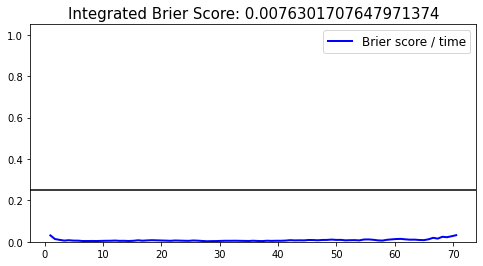

0.9845033221905823


In [27]:
brier_res, ibs, figure = dws.b_index(X_train.values, T_train, E_train, X_test.values, T_test, E_test, survival_predictions.T, plot=True)
figure.show()
mlt, res = dws.c_index(pi, alpha, beta, T_test, E_test)
print(res)

In [ ]:
from pysurvival.models.non_parametric import KaplanMeierModel

kmf = KaplanMeierModel()
kmf.fit(T_test, E_test)

T = torch.FloatTensor(dws.times[:,np.newaxis,np.newaxis])
mix = Categorical(pi)
comp = Weibull(alpha, beta, validate_args=None)
pdf = torch.sum(MixtureSameFamily(mix, comp).log_prob(T).exp(), (1,2)).data.numpy()

l = []
N = T_test.shape[0]
for i in dws.times:
    l.append(N*kmf.predict_density(i))

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=dws.times, y=pdf, mode='lines', name='predicted'))
fig.add_trace(go.Scatter(x=dws.times, y=l,mode='lines',name='actual'))
fig.show()

In [31]:
data_test.loc[(data_test[event_column]==1) & (data_test[time_column]>=45) & (data_test[time_column]<=50)].index.values

array([ 241,  475,  535,  620,  784,  829,  969,  975, 1013, 1085, 1259,
       1261, 1308, 1471, 1561, 1601, 1683, 1734, 1875, 2025, 2068])

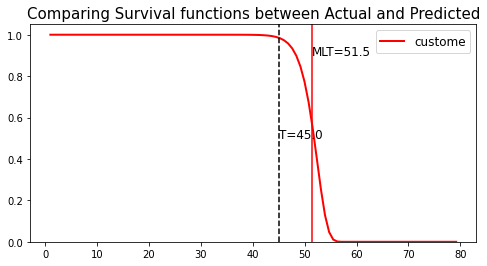

In [39]:
k = 2
t = T_test[k]
l_predicted = survival_predictions[:,k]
'''pys_predicted = lmtlr.predict_survival(X_test.iloc[[k]].values).flatten()
nmtlr_predicted = n_mtlr.predict_survival(X_test.iloc[[k]].values).flatten()'''

fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(dws.times, l_predicted.flatten(), color='red', label='custome', lw=2)
'''plt.plot(lmtlr.times, pys_predicted, color='blue', label='pysurvival', lw=2)
plt.plot(n_mtlr.times, nmtlr_predicted, color='green', label='pysurvival nmtlr', lw=2)'''


plt.axvline(x=t, color='black', ls ='--')
ax.annotate('T={:.1f}'.format(t), xy=(t, 0.5), xytext=(t, 0.5), fontsize=12)
plt.axvline(x=mlt[k], color='red', ls ='-')
ax.annotate('MLT={:.1f}'.format(mlt[k]), xy=(mlt[k], 0.5), xytext=(mlt[k], 0.9), fontsize=12)

# Show everything
title = "Comparing Survival functions between Actual and Predicted"
plt.legend(fontsize=12)
plt.title(title, fontsize=15)
plt.ylim(0, 1.05)
plt.show()
# the probability that an individual within the population will survive longer than time t.
#Survival Function defines the probability that the event of interest has not occurred at time t 

In [30]:
pd.DataFrame({'Event': E_test, 'Tenur': T_test, 'MLT': mlt})

,Event,Tenur,MLT
0,0,72,80.182404
1,0,66,67.508879
2,0,45,51.479415
3,0,72,81.688753
4,0,68,76.295180
...,...,...,...
2105,0,70,80.758229
2106,1,66,70.755865
2107,0,72,90.816279
2108,0,72,77.564932


In [37]:
churned_index = np.where(E_test)[0]
np.mean(np.abs(T_test.values[churned_index] - mlt[churned_index]))

1.4148247948876822

In [ ]:
float(alpha[k,0].data.numpy())

0.3128282427787781

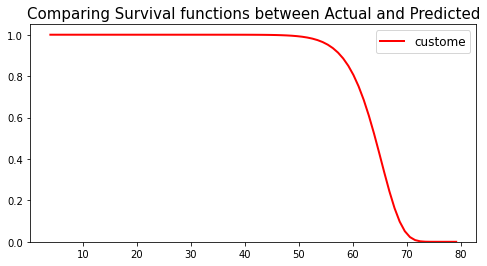

In [ ]:
d = torch.distributions.weibull.Weibull(65, 17, validate_args=None)
p = 0
#d = torch.distributions.weibull.Weibull(float(alpha[k,p].data.numpy()), float(beta[k,p].data.numpy()), validate_args=None)
t = np.linspace(4,79.2,80)
surv = 1 - d.cdf(dws.times)

fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(t, surv.data.numpy().flatten(), color='red', label='custome', lw=2)


# Show everything
title = "Comparing Survival functions between Actual and Predicted"
plt.legend(fontsize=12)
plt.title(title, fontsize=15)
plt.ylim(0, 1.05)
plt.show()
# the probability that an individual within the population will survive longer than time t.
#Survival Function defines the probability that the event of interest has not occurred at time t 

In [ ]:
d = Weibull(torch.tensor([[1.0, 3.3],[46.3, 119.21]]), torch.tensor([[5.0, 9.45], [45.8, 177.85]]), validate_args=None)
t = np.linspace(4,79.2,2)
t = t[:,np.newaxis]
d.log_prob(t)

In [ ]:
t

array([[ 4. ],
       [79.2]])

In [ ]:
d = Weibull(46.3, 45.8, validate_args=None)
t = np.linspace(4,79.2,2)
t = t[:,np.newaxis]
d.log_prob(79.2)

tensor(-4.7643e+10)

In [ ]:
from torch.distributions.independent import Independent

mix = Categorical(torch.tensor([[0.1, 0.40, 0.5], [0.5, 0.30, 0.2], [0.7, 0.25, 0.05], [0.8, 0.10, 0.1]]))
comp = Weibull(torch.tensor([[1.0, 3.3, 10.24],[46.3, 119.21, 11.54],[11.3, 32.21, 7.54],[90.3, 14.21, 71.54]]), 
               torch.tensor([[5.0, 9.45, 45.6], [45.8, 177.85, 250.6],[29.3, 37.21, 55.54],[101.3, 302.21, 70.54]]), validate_args=None)
mw = MixtureSameFamily(mix, comp)
t = torch.tensor(np.linspace(4,79.2,4))#
#t = t[:,np.newaxis]
mw.log_prob(t)

tensor([-4.3977e+00, -2.1561e+01, -2.4541e+08, -1.3264e+01],
       dtype=torch.float64)

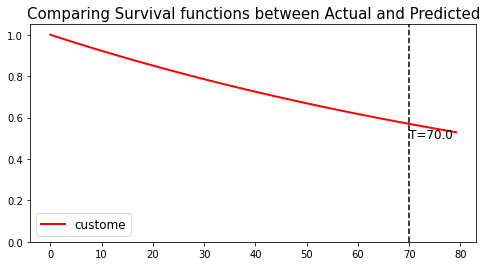

In [ ]:
from torch.distributions.independent import Independent

k=60
mix = Categorical(pi[k, :])
comp = Weibull(alpha[k,:], beta[k,:], validate_args=None)
mw = MixtureSameFamily(mix, comp)
t = torch.tensor(np.linspace(0,79.2,100)[:,np.newaxis,np.newaxis])
surv = 1 - mw.cdf(t)

fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(torch.squeeze(t), surv.data.numpy().flatten(), color='red', label='custome', lw=2)

t = T_train[k]
plt.axvline(x=t, color='black', ls ='--')
ax.annotate('T={:.1f}'.format(t), xy=(t, 0.5), xytext=(t, 0.5), fontsize=12)

# Show everything
title = "Comparing Survival functions between Actual and Predicted"
plt.legend(fontsize=12)
plt.title(title, fontsize=15)
plt.ylim(0, 1.05)
plt.show()
# the probability that an individual within the population will survive longer than time t.
#Survival Function defines the probability that the event of interest has not occurred at time t 

In [ ]:
from google.colab import files
times = pd.DataFrame(dws.times)
times.to_csv('dws_times.csv')
files.download('dws_times.csv')

surv = pd.DataFrame(survival_predictions.T)
surv.to_csv('dws_telecom_surv_pred.csv')
files.download('dws_telecom_surv_pred.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
mlt = pd.DataFrame(mlt)
mlt.to_csv('mlt.csv')
files.download('mlt.csv')
mlt

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,0
0,77.194321
1,66.478455
2,48.424870
3,80.043579
4,69.554848
...,...
2105,69.995796
2106,68.786926
2107,87.325706
2108,75.409683
